In [37]:
import sys 
sys.path.append("..")
import matplotlib.pyplot as plt 
import cv2 
import numpy as np
print("Done.")

import numpy as np 
import ray 
import cv2


# From the calibration experiment 
REALSENSE = np.array([[642.346680, 0, 345.860555], 
                      [0,644.245300, 257.557426],
                      [0,0,0]])

UNITY = np.array([[387.386, 0, 320], 
                      [0,387.386, 240],
                      [0,0,0]])


UNITY2 = np.array([[387.386, 0, 160], 
        [0,387.386, 30],
        [0,0,0]])

ZED2I = np.array([[700.819, 0, 665.465], 
                      [0,700.819, 371.953],
                      [0,0,0]])

# From the offical homepage 
REALSENSE2 = np.array([[382.01800537109375, 0, 323.56512451171875], 
                      [0,382.01800537109375, 236.67425537109375,],
                      [0,0,0]])

@ray.remote
def unity_ortho_projection(image, INTRINSIC_NAME="unity"):
    # Preprocessing 
    image = np.array(image)
    image = image.reshape((320, 180)) # Image shape [Width x Height]
    image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    # Orthographic projection 
    points = get_pointcloud(image*3.535, INTRINSIC_NAME)
    rot_mat = Rotation_X(-np.deg2rad(40))    
    trans_mat = Translation(x=-0., y=0.3, z=1.25-0.79)
    homo_mat  = HT_matrix(Rotation=rot_mat, Position=trans_mat) 
    homo_inv_mat = np.linalg.inv(homo_mat)
    new_points = transform_pointcloud(points, homo_inv_mat)
    new_bounds = np.array([[-0.45,0.45], 
                        [-1.0,-0.3],
                        [-1,2]])
    ortho_image = get_heightmap(new_points, new_bounds, pixel_size=0.0045)/2
    ortho_image_new = restore(ortho_image)
    ortho_image_new2 = restore(ortho_image_new)
    ortho_image_final = ortho_image_new2[35:-25,4:-4]
    ortho_image_final = normalization(ortho_image_final)
    return ortho_image_final 

def realworld_ortho_proejction3(data, INTRINSIC_NAME="realsense"):
    points = get_pointcloud(data*0.00345, INTRINSIC_NAME) # *0.004/bal_coef1*bal_coef2
    # Homogeneous Matrix 
    # rot_y_mat = Rotation_X(-np.deg2rad(30))
    # trans_mat = Translation(x=-0., y=0.0, z=0)
    # homo_mat = HT_matrix(Rotation=rot_y_mat, Position=trans_mat)
    homo_inv_mat = np.array([[ 1.,         0.,          0.,     0.],
                             [ 0.,         0.8660254, -0.5,     0.],
                             [ 0.,         0.5,        0.8660254,  0.],
                             [ 0.,         0.,         0.,         1.]])
    # Transform
    new_points = transform_pointcloud(points, homo_inv_mat)

    # Boundary 
    new_bounds = np.array([[-0.45,0.45], 
                    [-1.11,-0.3], #[-0.8, -0.2]
                    [-0.795,2]])

    ortho_image = get_heightmap(new_points*2.5, new_bounds, pixel_size=0.0045) #1.4
    ortho_image = restore3(ortho_image)
    ortho_image = restore3(ortho_image)
    ortho_image = restore3(ortho_image)
    ortho_image_final = ortho_image[84:,4:-4]
    ortho_image_final = normalization(ortho_image_final)
    return ortho_image_final

def realworld_ortho_proejction(data, INTRINSIC_NAME="realsense"):
    points = get_pointcloud(data*0.00345, INTRINSIC_NAME) # *0.004/bal_coef1*bal_coef2
    # Homogeneous Matrix 
    rot_y_mat = Rotation_X(-np.deg2rad(30))
    trans_mat = Translation(x=-0., y=0.0, z=0)
    homo_mat = HT_matrix(Rotation=rot_y_mat, Position=trans_mat)
    homo_inv_mat = np.linalg.inv(homo_mat)

    # Transform
    new_points = transform_pointcloud(points, homo_inv_mat)

    # Boundary 
    new_bounds = np.array([[-0.45,0.45], 
                    [-1.11,-0.3], #[-0.8, -0.2]
                    [-0.795,2]])

    ortho_image = get_heightmap(new_points*2.5, new_bounds, pixel_size=0.0045) #1.4
    ortho_image = restore(ortho_image)
    ortho_image = restore(ortho_image)
    ortho_image = restore(ortho_image)
    ortho_image_final = ortho_image[84:,4:-4]
    ortho_image_final = normalization(ortho_image_final)
    return ortho_image_final

def realworld_ortho_proejction2(data, INTRINSIC_NAME="realsense"):
    points = get_pointcloud(data*0.00345, INTRINSIC_NAME) # *0.004/bal_coef1*bal_coef2
    # Homogeneous Matrix 
    rot_y_mat = Rotation_X(-np.deg2rad(30))
    trans_mat = Translation(x=-0., y=0.0, z=0)
    homo_mat = HT_matrix(Rotation=rot_y_mat, Position=trans_mat)
    homo_inv_mat = np.linalg.inv(homo_mat)

    # Transform
    new_points = transform_pointcloud(points, homo_inv_mat)

    # Boundary 
    new_bounds = np.array([[-0.45,0.45], 
                    [-1.11,-0.3], #[-0.8, -0.2]
                    [-0.795,2]])

    ortho_image = get_heightmap(new_points*2.5, new_bounds, pixel_size=0.0045) #1.4
    ortho_image = restore2(ortho_image)
    ortho_image = restore2(ortho_image)
    ortho_image = restore2(ortho_image)
    ortho_image_final = ortho_image[84:,4:-4]
    ortho_image_final = normalization(ortho_image_final)
    return ortho_image_final

def normalization(ortho_image):
    return (ortho_image-np.min(ortho_image))/(np.max(ortho_image)-np.min(ortho_image))
    
def restore(ortho_image):
    ortho_image_new = np.zeros(shape=(ortho_image.shape[0], ortho_image.shape[1]))
    for i in range(1,ortho_image.shape[0]): 
        for j in range(ortho_image.shape[1]):
            if ortho_image[i][j]==0: 
                if np.average(ortho_image[i-1:i+1,j])*2 == np.nan:
                    pass 
                else:
                    ortho_image_new[i][j] = np.average(ortho_image[i-1:i+1,j])*2
            else: 
                ortho_image_new[i][j] = ortho_image[i][j]
    
    for i in range(2,ortho_image_new.shape[0]-2): 
        for j in range(2,ortho_image_new.shape[1]-2):
            if ortho_image_new[i+2][j]==0 and ortho_image_new[i-2][j]==0: 
                ortho_image_new[i][j]=0
            if ortho_image_new[i][j+2]==0 and ortho_image_new[i][j-2]==0: 
                ortho_image_new[i][j]=0
    return ortho_image_new

def restore2(ortho_image):
    ortho_image_new = np.zeros(shape=(ortho_image.shape[0], ortho_image.shape[1]))
    i_lst, j_lst = np.where(ortho_image==0)
    for i, j in zip(i_lst, j_lst):
        if np.average(ortho_image[i-1:i+1,j])*2 == np.nan:
            pass 
        else:
            ortho_image_new[i][j] = np.average(ortho_image[i-1:i+1,j])*2
    ortho_image_new += ortho_image
    return ortho_image_new 

def restore3(ortho_image):
    ortho_image_new = np.zeros(shape=(ortho_image.shape[0], ortho_image.shape[1]))
    i_lst, j_lst    = np.where(ortho_image==0)
    sel_value       = np.array([np.average(ortho_image[i-1:i+1,j])*2 if np.isfinite(np.average(ortho_image[i-1:i+1,j])*2) else 0 for (i, j) in zip(i_lst, j_lst)])
    ortho_image_new[i_lst, j_lst] = sel_value
    ortho_image_new+=ortho_image
    i_idx = np.arange(2,ortho_image_new.shape[0]-2)
    j_idx = np.arange(2,ortho_image_new.shape[1]-2)
    i_lst2 = np.array([(i,j) for i in i_idx for j in j_idx if ((ortho_image_new[i+2][j]==0) and (ortho_image_new[i-2][j]==0) or (ortho_image_new[i][j+2]==0) and (ortho_image_new[i][j-2]==0))])
    ortho_image_new[i_lst2[:,0], i_lst2[:,1]]=0
    return ortho_image_new 

def get_pointcloud(depth, intrinsics_name):
    if intrinsics_name == "unity":
        intrinsics=UNITY2 
    elif intrinsics_name == "realsense":
        intrinsics=REALSENSE 
    elif intrinsics_name == "zed":
        intrinsics=ZED2I
    height, width = depth.shape
    xlin = np.linspace(0, width - 1, width)
    ylin = np.linspace(0, height - 1, height)
    px, py = np.meshgrid(xlin, ylin)
    px = (px - intrinsics[0, 2]) * (depth / intrinsics[0, 0])
    py = (py - intrinsics[1, 2]) * (depth / intrinsics[1, 1])
    points = np.float32([px, py, depth]).transpose(1, 2, 0)
    return points

def get_heightmap(points, bounds, pixel_size):
  width = int(np.round((bounds[0, 1] - bounds[0, 0]) / pixel_size))
  height = int(np.round((bounds[1, 1] - bounds[1, 0]) / pixel_size))
  heightmap = np.zeros((height, width), dtype=np.float32)
  # Filter out 3D points that are outside of the predefined bounds.
  ix = (points[Ellipsis, 0] >= bounds[0, 0]) & (points[Ellipsis, 0] < bounds[0, 1]) # Range of the X
  iy = (points[Ellipsis, 1] >= bounds[1, 0]) & (points[Ellipsis, 1] < bounds[1, 1]) # Range of the Y
  iz = (points[Ellipsis, 2] >= bounds[2, 0]) & (points[Ellipsis, 2] < bounds[2, 1]) # Range of the Z 
  valid = ix & iy & iz
  points = points[valid]
  points.shape
  # Sort 3D points by z-value, which works with array assignment to simulate
  # z-buffering for rendering the heightmap image.
  iz = np.argsort(points[:, -1])
  points = points[iz]
  px = np.int32(np.floor((points[:, 0] - bounds[0, 0]) / pixel_size))
  py = np.int32(np.floor((points[:, 1] - bounds[1, 0]) / pixel_size))
  px = np.clip(px, 0, width - 1)
  py = np.clip(py, 0, height - 1)
  heightmap[py, px] = points[:, 2] - bounds[2, 0] # Depth value 
  return heightmap


def transform_pointcloud(points, transform):
  padding = ((0, 0), (0, 0), (0, 1))
  homogen_points = np.pad(points.copy(), padding,
                          'constant', constant_values=1)
  for i in range(3):
    points[Ellipsis, i] = np.sum(transform[i, :] * homogen_points, axis=-1)
  return points

def rot_e():
    e = np.array([[1, 	       0, 	      0],
             	  [0,          1,         0],
             	  [0,          0,         1]])
    return e


def rot_x(rad):
    roll = np.array([[1, 	       0, 	         0],
             		 [0, np.cos(rad), -np.sin(rad)],
             		 [0, np.sin(rad),  np.cos(rad)]])
    return roll 


def rot_y(rad):
    pitch = np.array([[np.cos(rad), 0, np.sin(rad)],
                      [0,		    1, 	         0],
                      [-np.sin(rad),0, np.cos(rad)]])
    return pitch


def rot_z(rad):
    yaw = np.array([[np.cos(rad), -np.sin(rad),  0],
         	        [np.sin(rad),  np.cos(rad),  0],
              		[0, 			         0,  1]])
    return yaw 


def Rotation_E(): 
    e = np.array([[1, 	       0, 	      0,    0],
             	  [0,          1,         0,    0],
             	  [0,          0,         1,    0],
             	  [0,		   0,	      0,    0]])
    return e


def Rotation_X(rad):
    roll = np.array([[1, 	       0, 	      0,    0],
             		 [0, np.cos(rad), -np.sin(rad), 0],
             		 [0, np.sin(rad),  np.cos(rad), 0],
             		 [0,		   0,	      0,    0]])
    return roll 


def Rotation_Y(rad):
    pitch = np.array([[np.cos(rad), 0, np.sin(rad), 0],
              		  [0,		    1, 	         0, 0],
              		  [-np.sin(rad),0, np.cos(rad), 0],
              		  [0, 		    0, 	         0, 0]])
    return pitch


def Rotation_Z(rad):
    yaw = np.array([[np.cos(rad), -np.sin(rad),  0, 0],
         	        [np.sin(rad),  np.cos(rad),  0, 0],
              		[0, 			         0,  1, 0],
             		[0, 			         0,  0, 0]])
    return yaw 

def Translation(x , y, z):
    Position = np.array([[0, 0, 0, x],
                         [0, 0, 0, y],
                         [0, 0, 0, z],
                         [0, 0, 0, 1]])
    return Position


def HT_matrix(Rotation, Position):
    Homogeneous_Transform = Rotation + Position
    return Homogeneous_Transform


def pr2t(position, rotation): 
    position_4diag  = np.array([[0, 0, 0, position[0]],
                                [0, 0, 0, position[1]],
                                [0, 0, 0, position[2]], 
                                [0, 0, 0, 1]], dtype=object)
    rotation_4diag  = np.append(rotation,[[0],[0],[0]], axis=1)
    rotation_4diag_ = np.append(rotation_4diag, [[0, 0, 0, 1]], axis=0)
    ht_matrix = position_4diag + rotation_4diag_ 
    return ht_matrix


def t2p(ht_matrix):
    return ht_matrix[:-1, -1]


def t2r(ht_matrix):
    return ht_matrix[:-1, :-1]


def convert_from_uvd(u, v, d):
    pxToMetre = 1
    focalx = 642.346680
    focaly =  644.245300
    cx = 324.860555
    cy = 257.557426
    d *= pxToMetre
    x_over_z = (cx - u) / focalx
    y_over_z = (cy - v) / focaly
    z = d / np.sqrt(1. + x_over_z**2 + y_over_z**2)
    x = x_over_z * z
    y = y_over_z * z
    return x, y, z


Done.


In [38]:
image = np.load("./data/npy/1025_test11_norm.npy")
print("Shape: {}".format(image.shape))

Shape: (480, 640)


Shape: (96, 192)


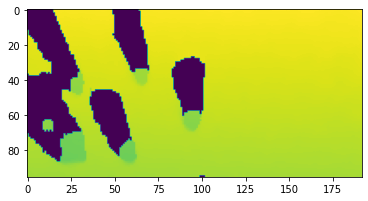

In [39]:
image = realworld_ortho_proejction(image)
print("Shape: {}".format(image.shape))
plt.imshow(image)

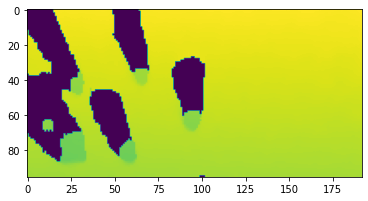

In [40]:
image = np.load("./data/npy/1025_test11_norm.npy")
ortho_image = realworld_ortho_proejction(image)
plt.imshow(ortho_image)

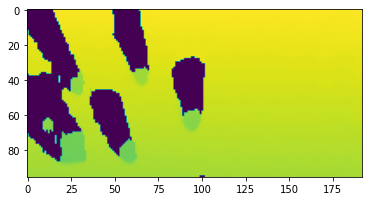

In [41]:
image = np.load("./data/npy/1025_test11_norm.npy")
ortho_image = realworld_ortho_proejction2(image)
plt.imshow(ortho_image)


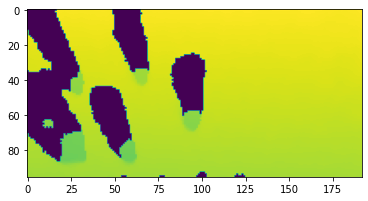

In [42]:
image = np.load("./data/npy/1025_test11_norm.npy")
ortho_image = realworld_ortho_proejction3(image)
plt.imshow(ortho_image)

In [43]:
image = np.load("./data/npy/1025_test11_norm.npy")
ortho_image = realworld_ortho_proejction_test(image)
ortho_image_new = np.zeros(shape=(ortho_image.shape[0], ortho_image.shape[1]))
i_lst, j_lst = np.where(ortho_image==0)
sel_value = np.array([np.average(ortho_image[i-1:i+1,j])*2 if np.isfinite(np.average(ortho_image[i-1:i+1,j])*2) else 0 for (i, j) in zip(i_lst, j_lst)])
ortho_image_new[i_lst, j_lst] = sel_value
ortho_image_new+=ortho_image
i_idx = np.arange(2,94)
j_idx = np.arange(2,190)
# ortho_image_new = ortho_image_new[2:-2]
i_lst2 = np.array([(i,j) for i in i_idx for j in j_idx if ((ortho_image_new[i+2][j]==0) and (ortho_image_new[i-2][j]==0) or (ortho_image_new[i][j+2]==0) and (ortho_image_new[i][j-2]==0))])
ortho_image_new[i_lst2[:,0], i_lst2[:,1]]=0
plt.imshow(ortho_image_new)

NameError: name 'realworld_ortho_proejction_test' is not defined